In [1]:
## ALL IMPORTS FOR A NEW NOTEBOOK

import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm
import time

font = {'size'   : 20}

matplotlib.rc('font', **font)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SEED = 947
torch_utils.seed_everything(SEED)

In [3]:
import spacy
from torchtext import data, datasets
import torchtext
spacy_de = spacy.load("de")
spacy_en = spacy.load("en")

In [4]:
def tokenize_de(txt):
    return [tok.text for tok in spacy_de.tokenizer(txt)]
def tokenize_en(txt):
    return [tok.text for tok in spacy_en.tokenizer(txt)]

In [5]:
SRC = data.Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>", lower=True)
TRG = data.Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True)

In [6]:
train_data, valid_data, test_data = datasets.Multi30k.splits(exts=(".de",".en"), fields=(SRC, TRG))

In [7]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [8]:
BATCH_SIZE = 128
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),
    device=device
)

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim*2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        # src -- len(src) X batch_size
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        # src -- len(src) X batch_size X emb_dim
        ot, ht = self.rnn(embedded)
        # ot -- len(src) X batch_size X enc_hid_dim
        # ht -- num_dir*num_layer X batch_size X enc_hid_dim
        catted = torch.cat((ht[-2,:,:], ht[-1,:,:]), dim=1)
        # catted -- batch_size X enc_hid_dim*2
        ht = torch.tanh(self.fc(catted))
        # ht -- batch_size X dec_hid_dim
        return ot, ht

In [10]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear((enc_hid_dim*2)+dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
    def forward(self, ht, enc_out):
        # ht -- batch_size X dec_hid_dim
        # enc_out -- len(src) X batch_size X enc_hid_dim
        
        batch_size = enc_out.shape[1]
        src_len = enc_out.shape[0]
        
        htp = ht.unsqueeze(dim=0).repeat(src_len, 1, 1).permute(1,0,2)
        ht = ht.unsqueeze(dim=1).repeat(1, src_len, 1)
        
        # ht -- batch_size X len(src) X dec_hid_dim
        
        enc_out = enc_out.permute(1,0,2)
        # enc_out -- batch_size X len(src) X enc_hid_dim
        
        energy = torch.tanh(self.attn(torch.cat((ht, enc_out), dim=2)))
        # energy -- batch_size X len(src) X dec_hid_dim
        
        energy = energy.permute(0,2,1)
        # energy -- batch_size X dec_hid_dim X len(src)
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        # v -- batch_size X 1 X dec_hid_dim
        
        attention = torch.bmm(v, energy).squeeze(1)
        # attention -- batch_size X len(src)
        
        return F.softmax(attention, dim=1)

In [11]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super(Decoder, self).__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim*2)+emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim*2)+emb_dim+dec_hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, trg, ht, enc_out):
        # trg -- batch_size
        # ht -- batch_size X dec_hidden_dim
        # enc_out -- len(src) X batch_size X enc_hidden_dim *2
        
        trg = trg.unsqueeze(dim=0)
        # trg -- 1 X batch_size
        embedded = self.dropout(self.embedding(trg))
        # embedded -- 1 X batch_size X emb_dim
        
        a = self.attention(ht, enc_out).unsqueeze(dim=1)
        # a -- batch_size X 1 X len(src)
        
        enc_out = enc_out.permute(1, 0, 2)
        # enc_out -- batch_size X len(src) X enc_hidden_dim * 2
        
        weighted = torch.bmm(a, enc_out)
        # weighted -- batch_size X 1 X enc_hidden_dim*2

        weighted = weighted.permute(1, 0, 2)
        # weighted -- 1 X batch_size X enc_hidden_dim*2
        
        catted_yt_wt = torch.cat((weighted, embedded), dim=2)
        
        output, hidden = self.rnn(catted_yt_wt, ht.unsqueeze(dim=0))
        
        # output -- 1 X batch_size X dec_hid_dim
        # hidden -- 1 X batch_size X dec_hid_dim
        
        
        embedded = embedded.squeeze(dim=0)
        output = output.squeeze(dim=0)
        weighted = weighted.squeeze(dim=0)
        
        preds = self.fc_out(torch.cat((embedded, output, weighted), dim=1))
        
        return preds, hidden.squeeze(0)

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src -- len(src) X batch_size
        # trg -- len(trg) X batch_size
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        encoder_out, hidden = self.encoder(src)
        
        current_tokens = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(current_tokens, hidden, encoder_out)
            outputs[t] = output
            
            teacher_force = random.random()<teacher_forcing_ratio
            top1 = output.argmax(1)
            
            current_tokens = trg[t, :] if teacher_force else top1
        
        return outputs        

In [13]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [14]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    l=0
    
    for batch in tqdm(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, trg)
        out_dim = output.shape[-1]
        output = output[1:].view(-1, out_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        l+=loss.item()
    return l/(len(iterator))

In [15]:
def evaluate(model, iterator, criterion):
    model.eval()
    l=0
    
    with torch.no_grad():
        for batch in tqdm(iterator):
            src = batch.src
            trg = batch.trg

            output = model(src, trg)
            out_dim = output.shape[-1]
            output = output[1:].view(-1, out_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            l+=loss.item()
    return l/(len(iterator))

In [16]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512

ENC_DROP = 0.43
DEC_DROP = 0.57

torch_utils.clear_cuda()

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROP)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROP, attn)

model = Seq2Seq(enc, dec, device)

In [17]:
torch_utils.count_model_params(model)

20518917

In [18]:
criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi[TRG.pad_token])
optimizer = torch_utils.RAdam(model.parameters())
model = model.apply(init_weights).to(device)

In [19]:
N_EPOCHS = 43
BEST_MODEL_NAME = "NMT_JLAT.pt"
CLIP = 1
ea = torch_utils.EarlyStopping(patience=20,save_model_name=BEST_MODEL_NAME, verbose=True)
history = pd.DataFrame()


for e in range(N_EPOCHS):
    st = time.time()
    tl = train(model, train_iterator, optimizer, criterion, CLIP)
    vl = evaluate(model, valid_iterator, criterion)
    
    TPL = math.exp(tl)
    VPL = math.exp(vl)
    torch_utils.print_epoch_stat(e, time.time()-st, history, train_loss=tl, valid_loss=vl)
    print("\tTPL\t {:0.5}".format(TPL))
    print("\tVPL\t {:0.5}".format(VPL))
    ea(VPL, model)
    
    if ea.early_stop:
        print("STOPPING EARLY!!")
        break
torch_utils.clear_cuda()




EPOCH 1 Completed, Time Taken: 0:00:58.618962
	Train Loss 	5.88859857
	Valid Loss 	5.03750688
	TPL	 360.9
	VPL	 154.09
Found better solution (inf --> 154.085382).  Saving model ...





EPOCH 2 Completed, Time Taken: 0:00:59.109388
	Train Loss 	4.762331
	Valid Loss 	4.48408151
	TPL	 117.02
	VPL	 88.596
Found better solution (154.085382 --> 88.595539).  Saving model ...





EPOCH 3 Completed, Time Taken: 0:00:59.625684
	Train Loss 	4.44609858
	Valid Loss 	4.35346323
	TPL	 85.294
	VPL	 77.747
Found better solution (88.595539 --> 77.747254).  Saving model ...





EPOCH 4 Completed, Time Taken: 0:00:59.219080
	Train Loss 	4.21092449
	Valid Loss 	4.07391018
	TPL	 67.419
	VPL	 58.786
Found better solution (77.747254 --> 58.786379).  Saving model ...





EPOCH 5 Completed, Time Taken: 0:00:58.960022
	Train Loss 	4.01574422
	Valid Loss 	3.95117882
	TPL	 55.465
	VPL	 51.997
Found better solution (58.786379 --> 51.996625).  Saving model ...





EPOCH 6 Completed, Time Taken: 0:00:58.297580
	Train Loss 	3.77618366
	Valid Loss 	3.46939102
	TPL	 43.649
	VPL	 32.117
Found better solution (51.996625 --> 32.117178).  Saving model ...





EPOCH 7 Completed, Time Taken: 0:00:58.810653
	Train Loss 	3.36083269
	Valid Loss 	3.05436364
	TPL	 28.813
	VPL	 21.208
Found better solution (32.117178 --> 21.207685).  Saving model ...





EPOCH 8 Completed, Time Taken: 0:00:58.314422
	Train Loss 	2.94138317
	Valid Loss 	2.9474552
	TPL	 18.942
	VPL	 19.057
Found better solution (21.207685 --> 19.057395).  Saving model ...





EPOCH 9 Completed, Time Taken: 0:00:58.407914
	Train Loss 	2.63466707
	Valid Loss 	2.62091416
	TPL	 13.939
	VPL	 13.748
Found better solution (19.057395 --> 13.748286).  Saving model ...





EPOCH 10 Completed, Time Taken: 0:00:58.983827
	Train Loss 	2.37547258
	Valid Loss 	2.6250276
	TPL	 10.756
	VPL	 13.805
EarlyStopping counter: 1 out of 20





EPOCH 11 Completed, Time Taken: 0:00:59.676122
	Train Loss 	2.14589687
	Valid Loss 	2.38913333
	TPL	 8.5497
	VPL	 10.904
Found better solution (13.748286 --> 10.904040).  Saving model ...





EPOCH 12 Completed, Time Taken: 0:00:58.696705
	Train Loss 	1.95603672
	Valid Loss 	2.32468559
	TPL	 7.0712
	VPL	 10.223
Found better solution (10.904040 --> 10.223465).  Saving model ...





EPOCH 13 Completed, Time Taken: 0:00:58.927317
	Train Loss 	1.775436
	Valid Loss 	2.29990236
	TPL	 5.9029
	VPL	 9.9732
Found better solution (10.223465 --> 9.973209).  Saving model ...





EPOCH 14 Completed, Time Taken: 0:00:59.516881
	Train Loss 	1.66709966
	Valid Loss 	2.20542137
	TPL	 5.2968
	VPL	 9.0741
Found better solution (9.973209 --> 9.074074).  Saving model ...





EPOCH 15 Completed, Time Taken: 0:00:58.924519
	Train Loss 	1.53519707
	Valid Loss 	2.24177438
	TPL	 4.6422
	VPL	 9.41
EarlyStopping counter: 1 out of 20





EPOCH 16 Completed, Time Taken: 0:00:59.506059
	Train Loss 	1.40687173
	Valid Loss 	2.34981307
	TPL	 4.0832
	VPL	 10.484
EarlyStopping counter: 2 out of 20





EPOCH 17 Completed, Time Taken: 0:01:00.247948
	Train Loss 	1.31350464
	Valid Loss 	2.3932727
	TPL	 3.7192
	VPL	 10.949
EarlyStopping counter: 3 out of 20





EPOCH 18 Completed, Time Taken: 0:00:59.503482
	Train Loss 	1.21171719
	Valid Loss 	2.37360105
	TPL	 3.3592
	VPL	 10.736
EarlyStopping counter: 4 out of 20





EPOCH 19 Completed, Time Taken: 0:00:59.622015
	Train Loss 	1.13258814
	Valid Loss 	2.31191514
	TPL	 3.1037
	VPL	 10.094
EarlyStopping counter: 5 out of 20





EPOCH 20 Completed, Time Taken: 0:00:58.979383
	Train Loss 	1.07359862
	Valid Loss 	2.32225709
	TPL	 2.9259
	VPL	 10.199
EarlyStopping counter: 6 out of 20





EPOCH 21 Completed, Time Taken: 0:00:59.930149
	Train Loss 	0.984503345
	Valid Loss 	2.64134756
	TPL	 2.6765
	VPL	 14.032
EarlyStopping counter: 7 out of 20





EPOCH 22 Completed, Time Taken: 0:00:59.963068
	Train Loss 	0.911305406
	Valid Loss 	2.41620892
	TPL	 2.4876
	VPL	 11.203
EarlyStopping counter: 8 out of 20





EPOCH 23 Completed, Time Taken: 0:00:59.472446
	Train Loss 	0.862249045
	Valid Loss 	2.57562897
	TPL	 2.3685
	VPL	 13.14
EarlyStopping counter: 9 out of 20





EPOCH 24 Completed, Time Taken: 0:00:59.709548
	Train Loss 	0.800608816
	Valid Loss 	2.68277621
	TPL	 2.2269
	VPL	 14.626
EarlyStopping counter: 10 out of 20





EPOCH 25 Completed, Time Taken: 0:01:00.210530
	Train Loss 	0.750326608
	Valid Loss 	2.74775237
	TPL	 2.1177
	VPL	 15.608
EarlyStopping counter: 11 out of 20





EPOCH 26 Completed, Time Taken: 0:00:58.833725
	Train Loss 	0.71329438
	Valid Loss 	2.67348105
	TPL	 2.0407
	VPL	 14.49
EarlyStopping counter: 12 out of 20





EPOCH 27 Completed, Time Taken: 0:00:59.718032
	Train Loss 	0.670717245
	Valid Loss 	2.93439853
	TPL	 1.9556
	VPL	 18.81
EarlyStopping counter: 13 out of 20





EPOCH 28 Completed, Time Taken: 0:00:58.951801
	Train Loss 	0.628125093
	Valid Loss 	2.63196701
	TPL	 1.8741
	VPL	 13.901
EarlyStopping counter: 14 out of 20





EPOCH 29 Completed, Time Taken: 0:00:59.066520
	Train Loss 	0.593873967
	Valid Loss 	2.79987383
	TPL	 1.811
	VPL	 16.443
EarlyStopping counter: 15 out of 20





EPOCH 30 Completed, Time Taken: 0:00:59.549139
	Train Loss 	0.547727666
	Valid Loss 	2.8771494
	TPL	 1.7293
	VPL	 17.764
EarlyStopping counter: 16 out of 20





EPOCH 31 Completed, Time Taken: 0:01:00.618374
	Train Loss 	0.522167647
	Valid Loss 	2.74029735
	TPL	 1.6857
	VPL	 15.492
EarlyStopping counter: 17 out of 20





EPOCH 32 Completed, Time Taken: 0:01:00.606567
	Train Loss 	0.501844052
	Valid Loss 	3.19996578
	TPL	 1.6518
	VPL	 24.532
EarlyStopping counter: 18 out of 20





EPOCH 33 Completed, Time Taken: 0:00:59.808289
	Train Loss 	0.470583798
	Valid Loss 	3.14032072
	TPL	 1.6009
	VPL	 23.111
EarlyStopping counter: 19 out of 20





EPOCH 34 Completed, Time Taken: 0:00:59.964646
	Train Loss 	0.436554415
	Valid Loss 	3.17872691
	TPL	 1.5474
	VPL	 24.016
EarlyStopping counter: 20 out of 20
STOPPING EARLY!!


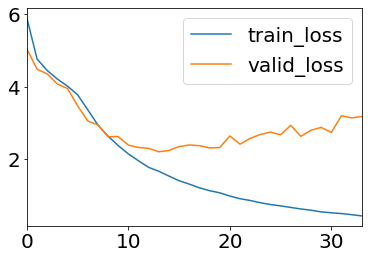

In [20]:
ax = history["train_loss"].plot()
history["valid_loss"].plot(ax=ax)
plt.legend()

In [21]:
test_loss = evaluate(model, test_iterator, criterion)

print("OF: LOSS -- {:0.5} PPL -- {:0.5}".format(test_loss, math.exp(test_loss)))


OF: LOSS -- 3.131 PPL -- 22.897


In [22]:
model.load_state_dict(torch.load(BEST_MODEL_NAME, map_location=device))

<All keys matched successfully>

In [23]:
test_loss = evaluate(model, test_iterator, criterion)

print("OF: LOSS -- {:0.5} PPL -- {:0.5}".format(test_loss, math.exp(test_loss)))


OF: LOSS -- 2.3029 PPL -- 10.003
